# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
We find lane lines on the road by applying this set of operations: 
1. Turn image from RGB to HSL for easier filtering of colors.
1. Get only white and yellow colors.
1. Apply gaussian blurr on the image to remove false positive edges, (good pre-processing step before applying canny edge detection). 
1. Do canny edge detection.
1. Apply region of interest.
1. Apply hough lines transform - detect lines.
1. Remove outliers from detected lines. If video, remember line slopes over time, filter out outliers.
1. Interpolate lane lines by applying least squares regression line.

This pipeline succesffully detects lines in all test images and 3 videos below, including the challenge video.

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Functions Used in Pipeline 

In [2]:
import math
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def region_of_interest_vertices(img):
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    y_line = ysize*0.611
    x_margin_bottom = xsize*0.05
    x_margin_top = xsize*0.427
    
    bottom_left = (x_margin_bottom, ysize)
    top_left = (x_margin_top, y_line)
    top_right = (xsize - x_margin_top, y_line)
    bottom_right = (xsize - x_margin_bottom, ysize)
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices

def draw_lines(img, lines, globalLeftSlopes, globalRightSlopes):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    leftLines = [];
    leftSlopes = [];
    rightLines = [];
    rightSlopes = [];
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if slope < 0:
                leftLines.append((x1, y1, x2, y2))
                leftSlopes.append(slope)
                globalLeftSlopes.append(slope)
            else:
                rightLines.append((x1, y1, x2, y2))
                rightSlopes.append(slope)
                globalRightSlopes.append(slope)
    

    leftLinePoints = removeOutliers(globalLeftSlopes, leftSlopes, leftLines)
    rightLinePoints = removeOutliers(globalRightSlopes, rightSlopes, rightLines)

    if len(leftLinePoints) > 1:
        leftP1, leftP2 = interpolate(img, leftLinePoints)
        cv2.line(img, leftP1, leftP2, [0, 0, 255], 10)
        
    if len(rightLinePoints) > 1:
        rightP1, rightP2 = interpolate(img, rightLinePoints)
        cv2.line(img, rightP1, rightP2, [0, 255, 0], 10)

def removeOutliers(globalSlopes, localSlopes, lines):
    """
    Returns array of points of lines that are not considered as outliers
    """
    finalPoints = []
    globalSlopesNp = np.array(globalSlopes)
    median = np.median(globalSlopesNp, axis=0)
    sd = np.std(globalSlopesNp, axis=0)
    for slope, line in zip(localSlopes, lines):
        if abs(slope) <= 0.1:
            continue
        if slope > median - 2*sd and slope < median + 2*sd:
            (x1,y1,x2,y2) = line
            finalPoints.append((x1, y1))
            finalPoints.append((x2, y2))
    return finalPoints
    

def interpolate(img, points):
    [vx,vy,x0,y0] = cv2.fitLine(np.array(points),cv2.DIST_L2,0,0.01,0.01)
    slope = vy/vx
    if abs(slope) <= 0.1:
        return (0, 0), (0, 0)
    # assuming line equation is y = slope*x + b
    b = y0 - slope*x0
    
    vertices = region_of_interest_vertices(img)
    leftY1 = img.shape[0]
    leftY2 = vertices[0][1][1] # our region of interest min Y value
    
    leftX1 = int((leftY1 - b) / slope)
    leftX2 = int((leftY2 - b) / slope)
    return (leftX1, leftY1), (leftX2, leftY2)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns detected hough lines
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Building pipeline to work on the images in the directory "test_images"

In [3]:
import os
img_names = os.listdir("test_images/")
img_names.remove(".DS_Store")

img_full_paths = list(map(lambda img_name: "test_images/" + img_name, img_names))
print(img_names)

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'challenge4.jpg', 'challenge2.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


In [4]:
# Helper function to plot all images at once
def show_images(images, img_names, save=False, save_prefix=''):
    cols = 2
    rows = len(images)/cols
    plt.figure(figsize=(15, 15))
    for i in range(0, len(images)):
        img_name = img_names[i]
        plt.subplot(rows, cols, i+1)
        img = images[i]
        cmap = None
        if len(img.shape) < 3:
            cmap = 'gray'
            
        plt.title(img_names[i])
        plt.imshow(img, cmap=cmap)
        if save:
            img_to_save = img
            if len(img.shape) is 3:
                img_to_save = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite('test_images_output/' + save_prefix + img_name, img_to_save)
        
    plt.tight_layout()
    plt.show()

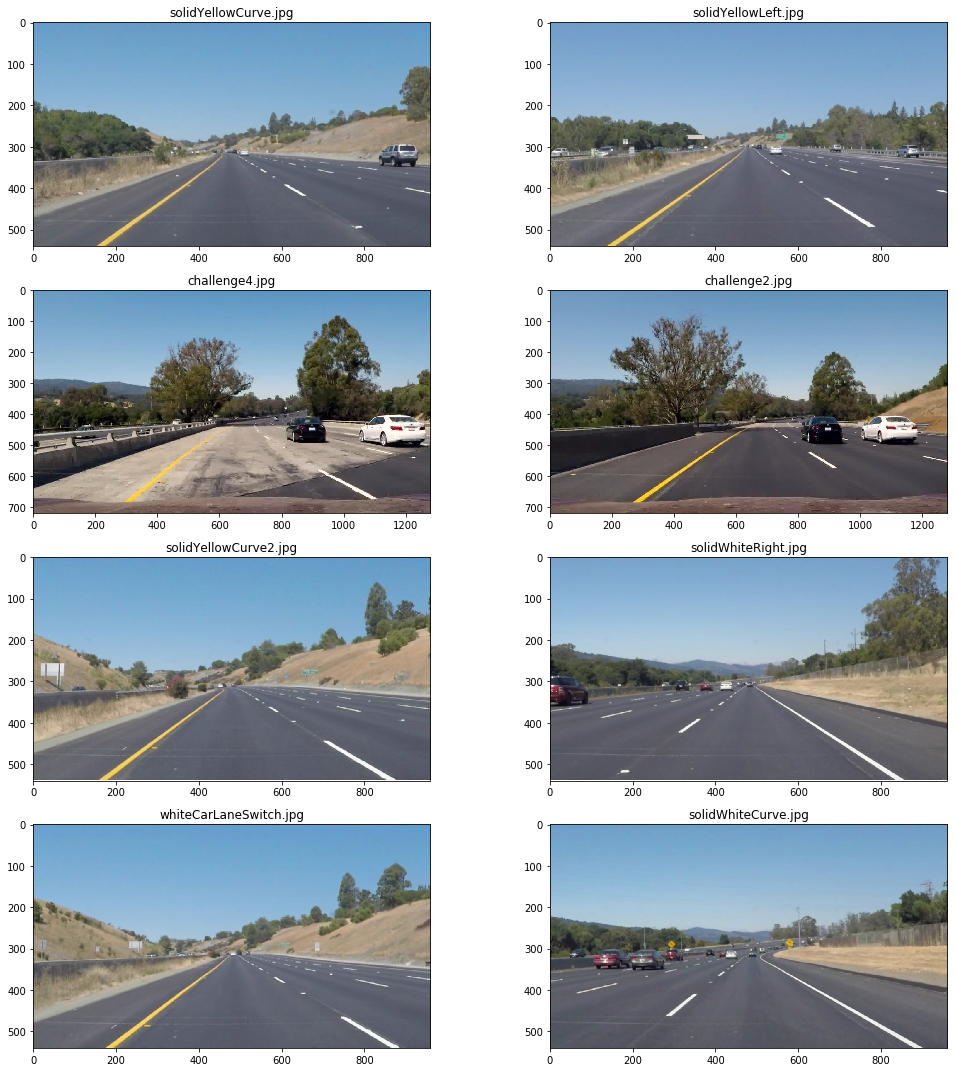

In [5]:
images = list(map(lambda img_path: mpimg.imread(img_path), img_full_paths))
show_images(images, img_names)

## Lane Finding Pipeline



### Convert to HSL color model (to detect white and yellow colors easier)

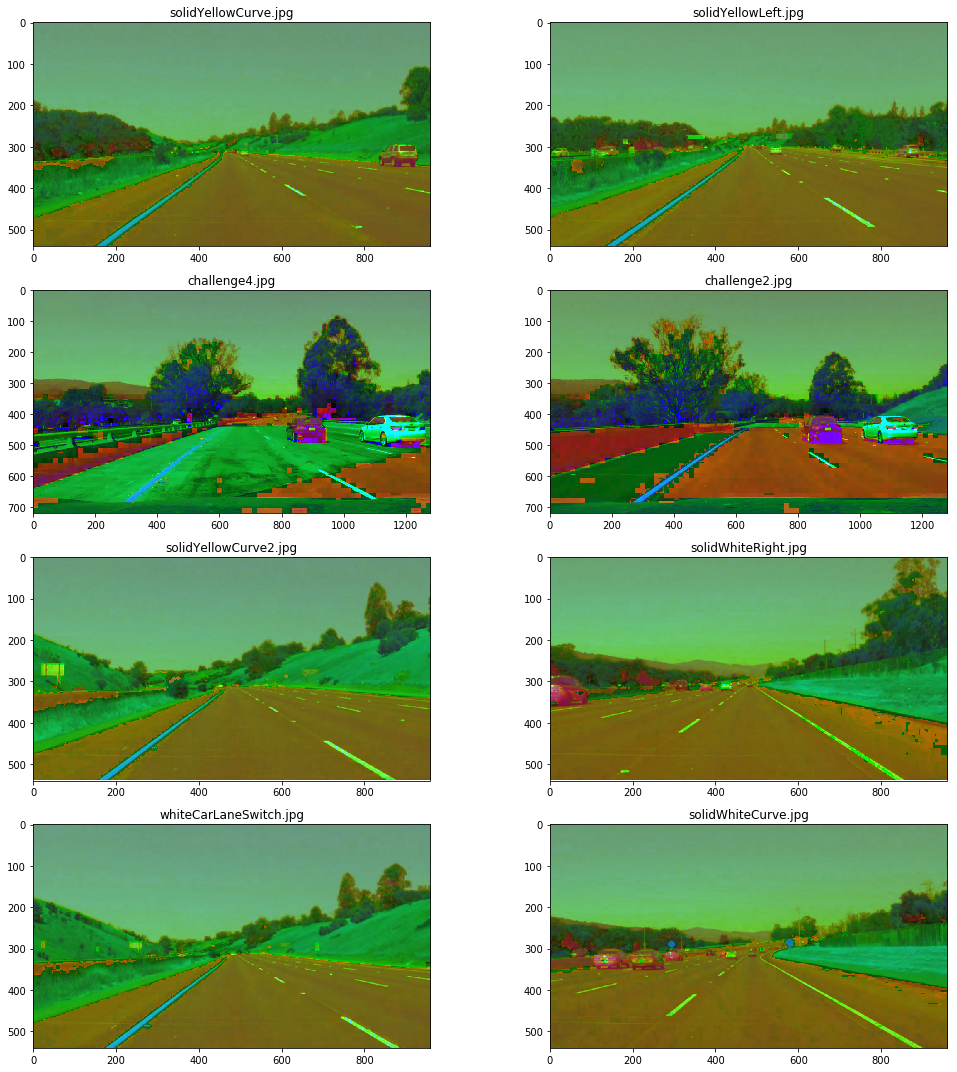

In [6]:
hls_images = list(map(lambda image: cv2.cvtColor(image, cv2.COLOR_RGB2HLS), images))
show_images(hls_images, img_names)

### Detect Yellow Color

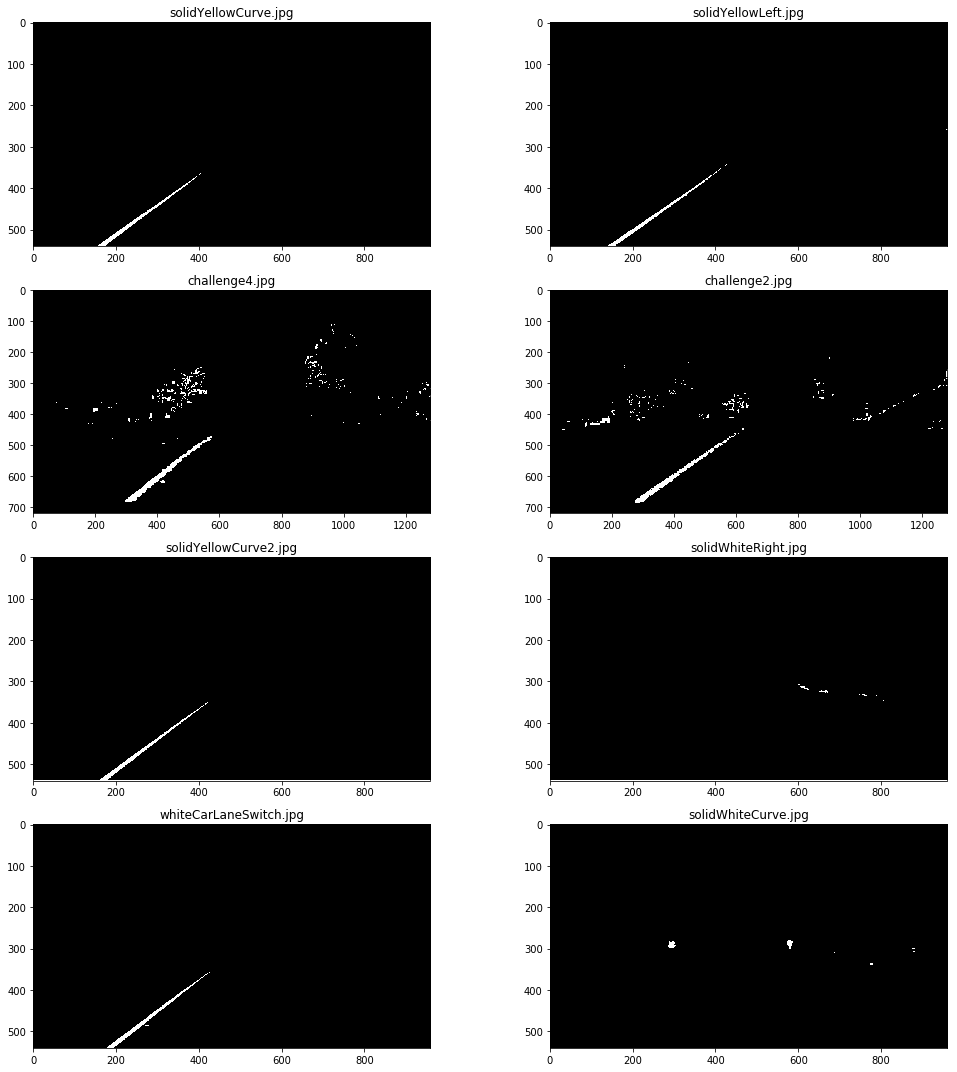

In [7]:
# yellow color thresholds in HSL image (encoded as HLS in opencv)
low_threshold = np.array([15, 30, 115], dtype=np.uint8)
high_threshold = np.array([35, 200, 255], dtype=np.uint8)

yellow_masks = list(map(lambda hls_img: cv2.inRange(hls_img, low_threshold, high_threshold), hls_images))
show_images(yellow_masks, img_names)

### Detect White Color

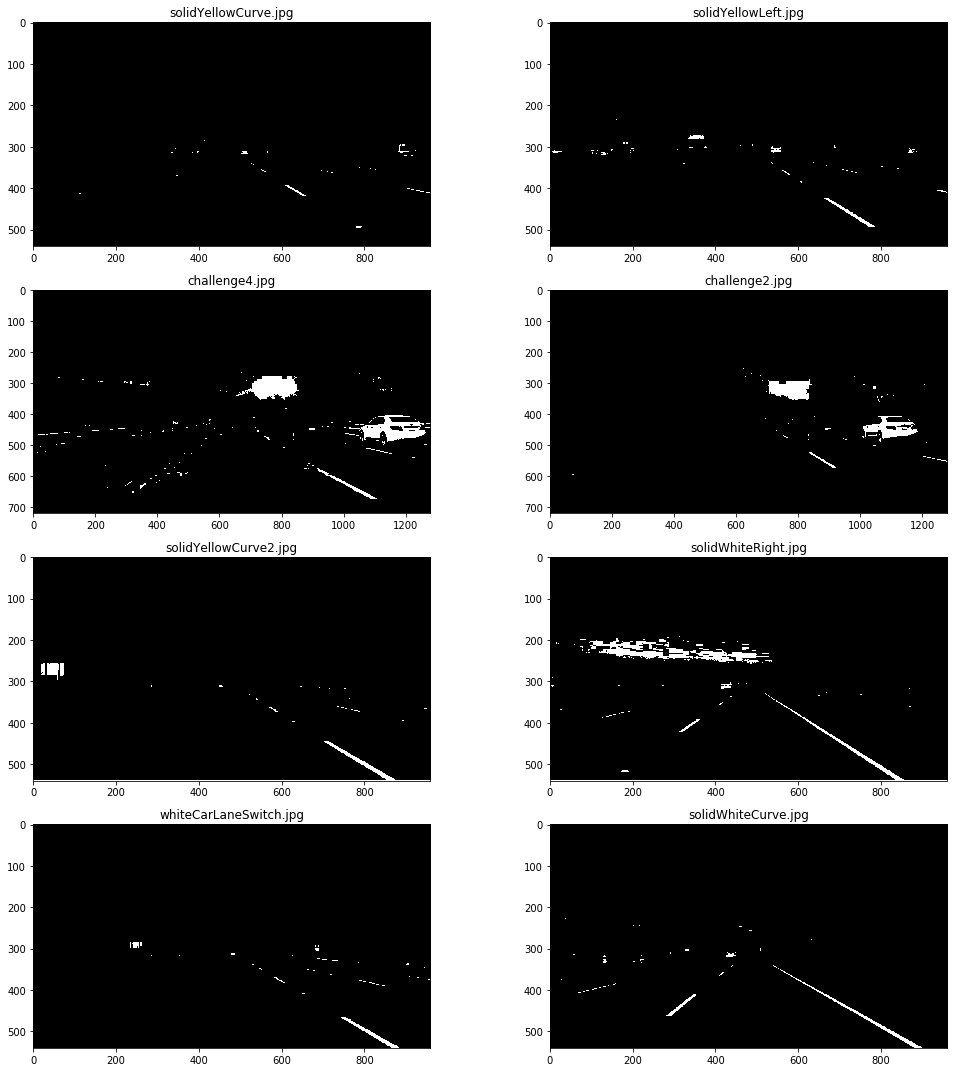

In [8]:
# white color thresholds in HSL image (encoded as HLS in opencv)
low_threshold = np.array([0, 200, 0], dtype=np.uint8)
high_threshold = np.array([180, 255, 255], dtype=np.uint8) 

white_masks = list(map(lambda hls_img: cv2.inRange(hls_img, low_threshold, high_threshold), hls_images))
show_images(white_masks, img_names)

### Combine white and yellow colors

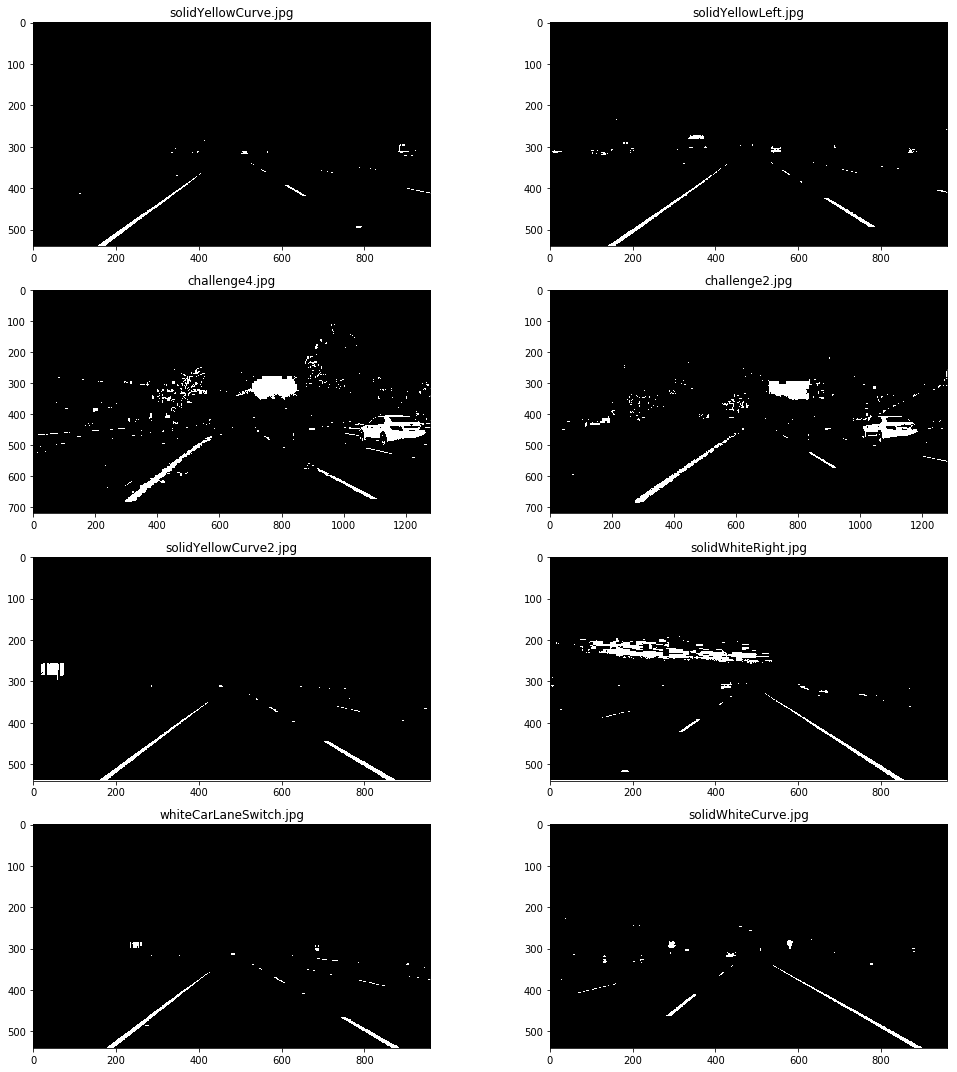

In [9]:
color_filtered_images = list(map(lambda masks: cv2.bitwise_or(masks[0], masks[1]), list(zip(yellow_masks, white_masks))))
show_images(color_filtered_images, img_names)

### Apply gaussian blur with kernel 11 on our images

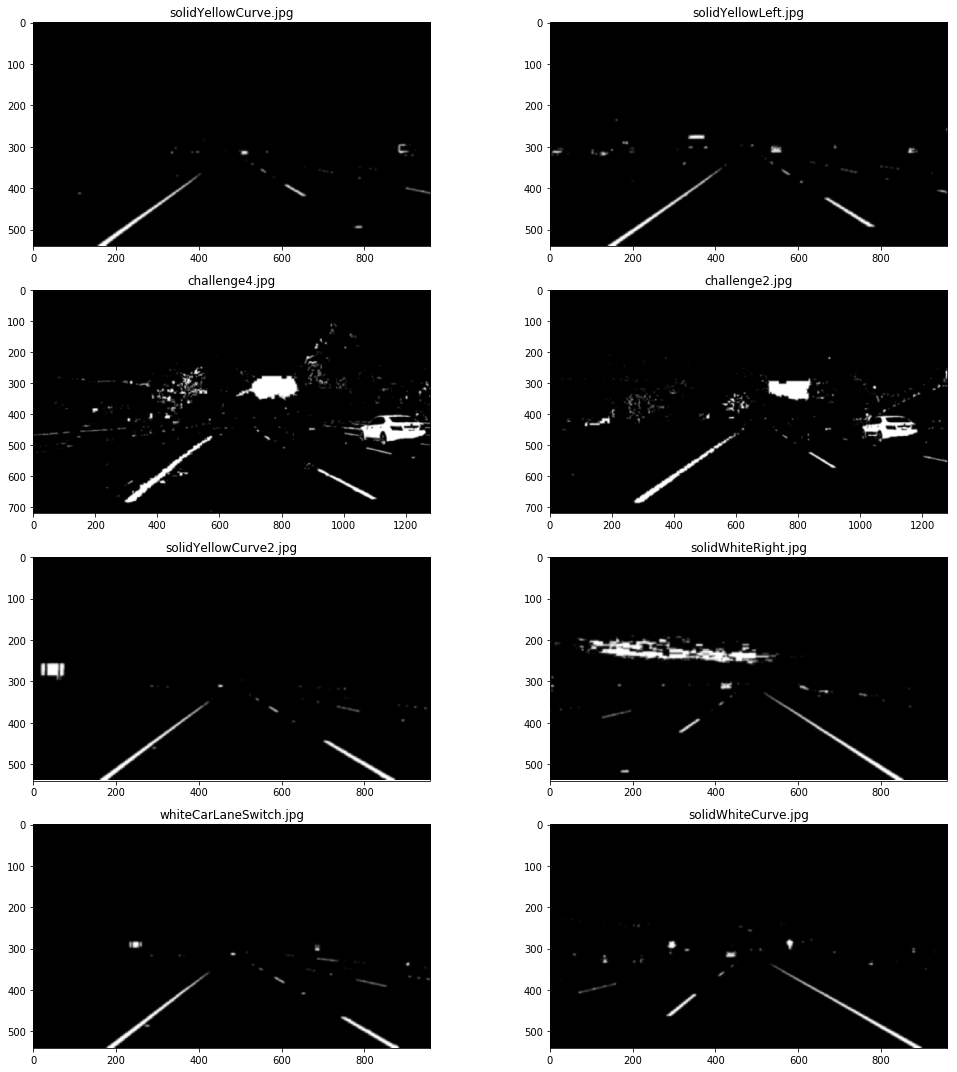

In [10]:
blurred_images = list(map(lambda img: gaussian_blur(img, 11), color_filtered_images))
show_images(blurred_images, img_names)

### Apply canny edge detection on our gauss blurred image

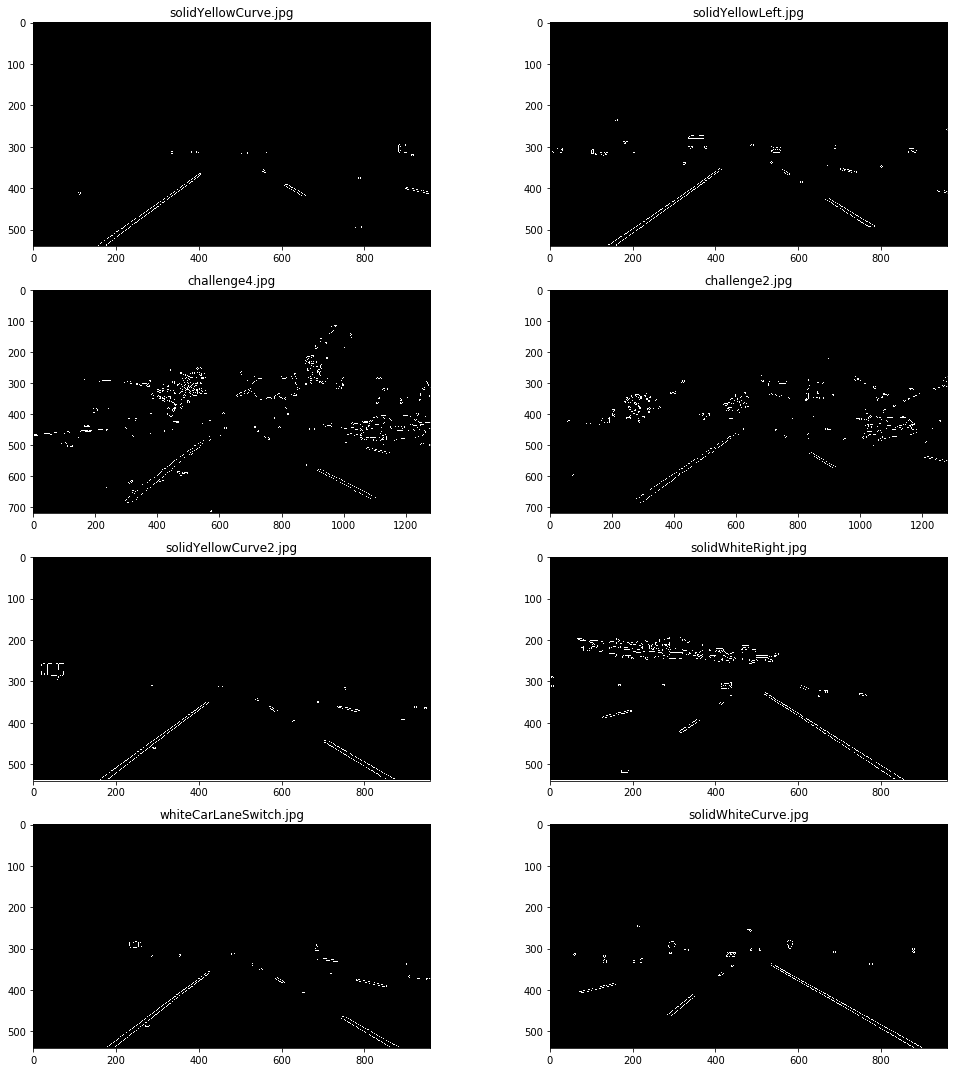

In [11]:
canny_images = list(map(lambda img: canny(img, 50, 150), blurred_images))
show_images(canny_images, img_names)

### Verify region of interest on a normal image for testing purposes

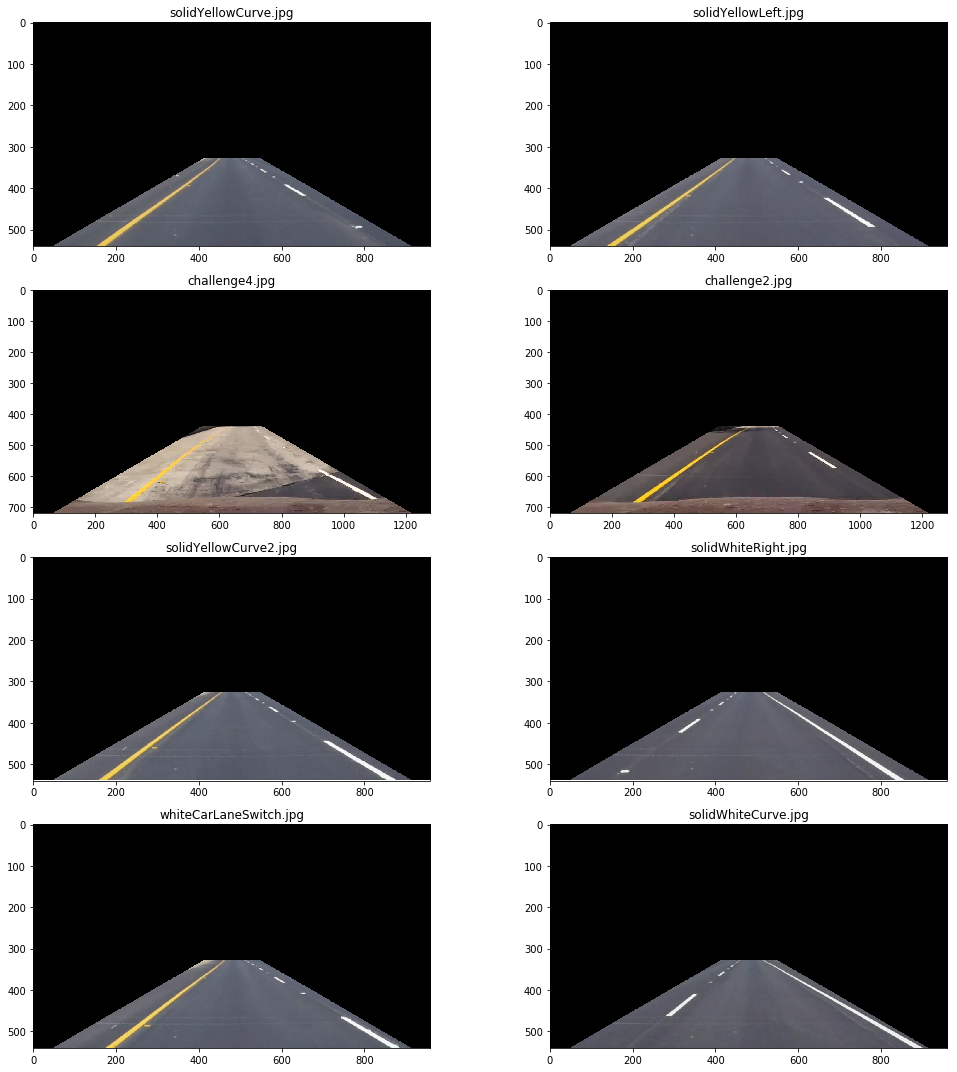

In [12]:
vertices = list(map(lambda img: region_of_interest_vertices(img), images))
original_images_with_roi = list(map(lambda arg: region_of_interest(arg[0], arg[1]), list(zip(images, vertices))))
show_images(original_images_with_roi, img_names)

### Apply region on canny image

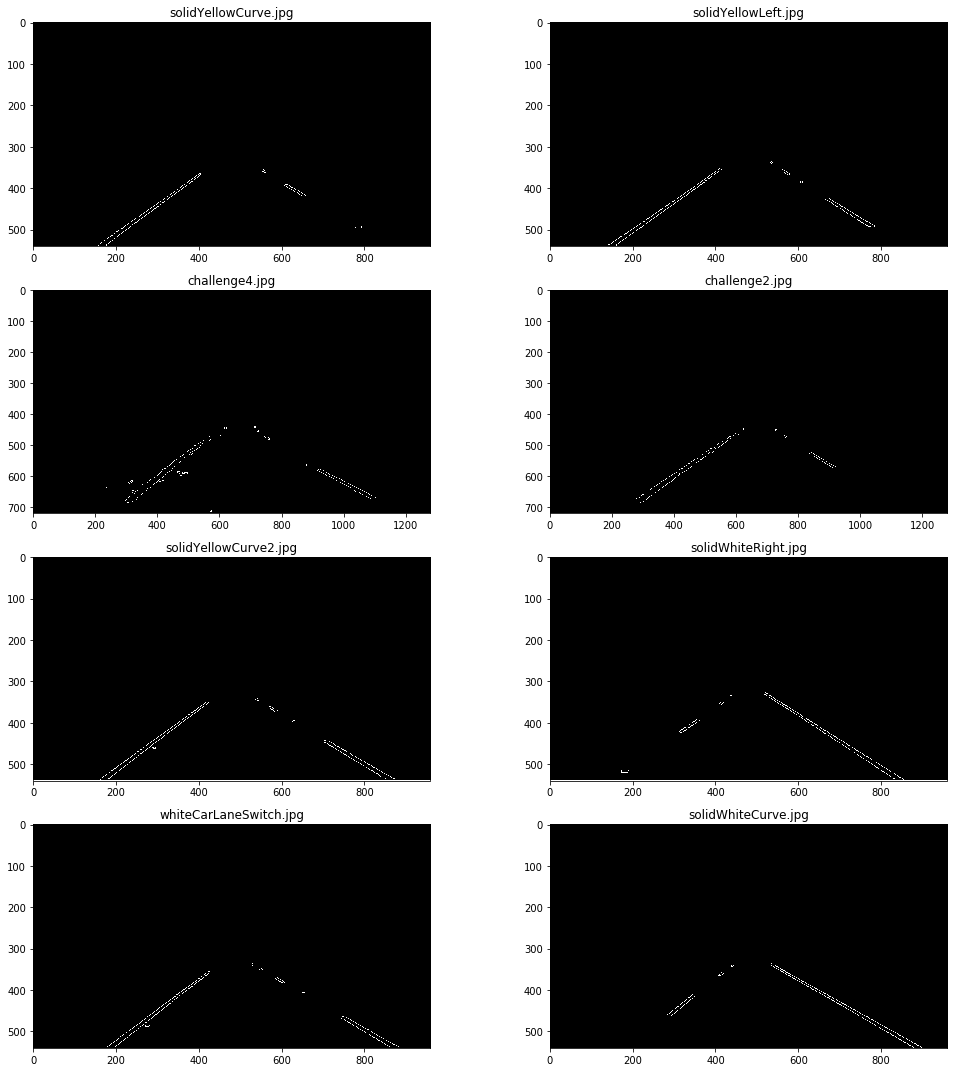

In [13]:
vertices = list(map(lambda img: region_of_interest_vertices(img), canny_images))
canny_images_with_roi = list(map(lambda arg: region_of_interest(arg[0], arg[1]), list(zip(canny_images, vertices))))
show_images(canny_images_with_roi, img_names)

### Apply Hough Tranform

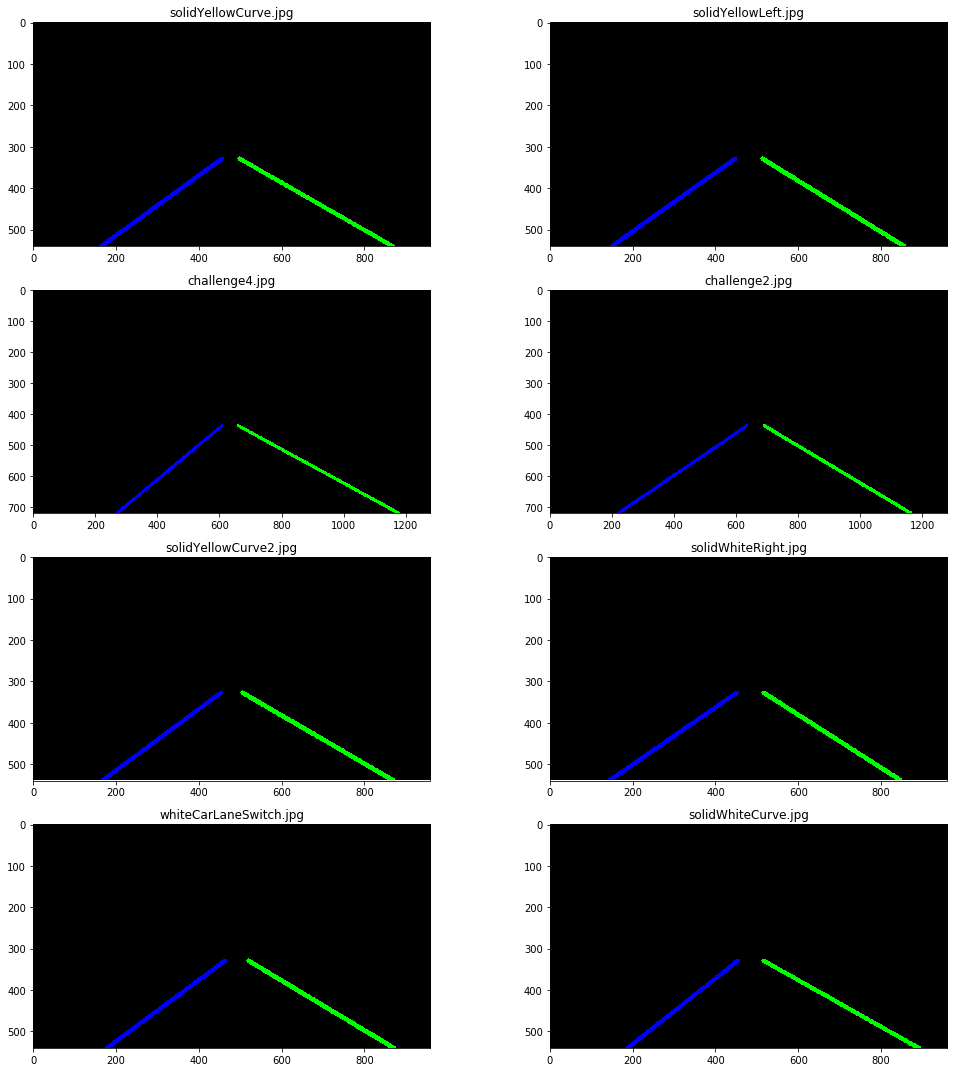

In [14]:
rho = 1
theta = np.pi / 180
threshold = 15
min_line_length = 20
max_line_gap = 10
hough_lines_images = []
for i, canny_roi in enumerate(canny_images_with_roi):
    lines = hough_lines(canny_roi, rho, theta, threshold, min_line_length, max_line_gap)
    hough_lines_img = np.zeros((canny_roi.shape[0], canny_roi.shape[1], 3), dtype=np.uint8)
    draw_lines(hough_lines_img, lines, [], [])
    hough_lines_images.append(hough_lines_img)

show_images(hough_lines_images, img_names)

### Overlay detected liens on the original image

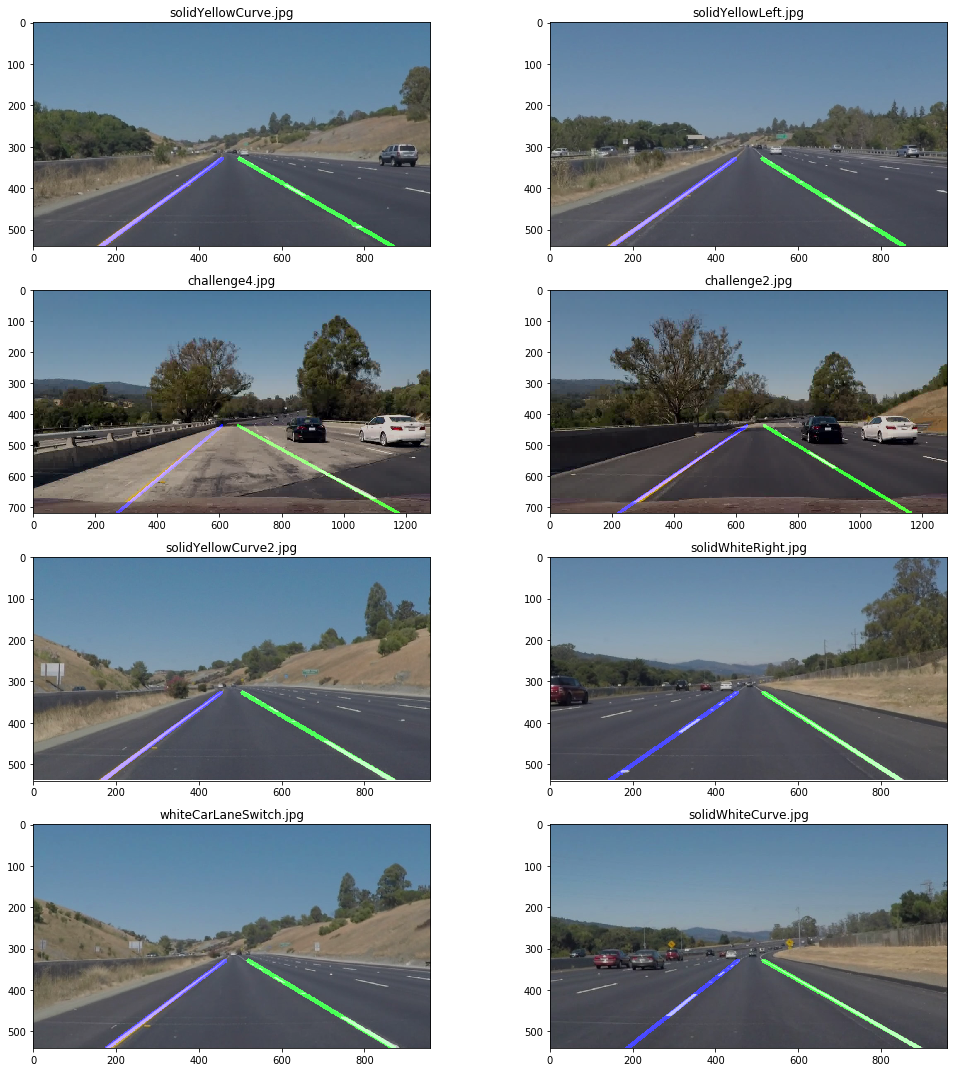

In [15]:
original_with_lines = list(map(lambda arg: weighted_img(arg[0], arg[1]), list(zip(hough_lines_images, images))))
show_images(original_with_lines, img_names)

## Test on Videos

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0434176/28549024 bytes (1.51007616/28549024 bytes (3.5%1761280/28549024 bytes (6.2%2367488/28549024 bytes (8.3%2973696/28549024 bytes (10.43465216/28549024 bytes (12.14169728/28549024 bytes (14.64775936/28549024 bytes (16.75373952/28549024 bytes (18.85971968/28549024 bytes (20.96561792/28549024 bytes (23.07168000/28549024 bytes (25.17774208/28549024 bytes (27.28364032/28549024 bytes (29.38929280/28549024 bytes (31.39560064/28549024 bytes (33.510149888/28549024 bytes (35.6%10756096/28549024 bytes (37.7%11345920/28549024 bytes (39.7%11902976/28549024 bytes (41.7%12468224/28549024 bytes (43.7%13131776/28549024 bytes (46.0%13754368/28549024 bytes (48.2%14360576/28549024 bytes (50.3%14966784/28549024 bytes (52.4%15572992/28549024 bytes (54.5%16179200/28549024 bytes (56.7%1

In [17]:
class LaneDetector:
    def __init__(self):
        self.globalLeftSlopes = []
        self.globalRightSlopes = []

    def process_image(self, image):
        # returns the final output (image where lines are drawn on lanes)
        
        # convert to HSL (HLS) image
        hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        
        # filter yellow color
        low_threshold = np.array([15, 30, 115], dtype=np.uint8)
        high_threshold = np.array([35, 200, 255], dtype=np.uint8)
        yellow_mask = cv2.inRange(hls_img, low_threshold, high_threshold)
        
        # filter white color
        low_threshold = np.array([0, 200, 0], dtype=np.uint8)
        high_threshold = np.array([180, 255, 255], dtype=np.uint8)
        white_mask = cv2.inRange(hls_img, low_threshold, high_threshold)
        
        # combine white and yellow colors
        color_filtered_img = cv2.bitwise_or(white_mask, yellow_mask)
        
        # apply gauss blur
        gauss_blur_img = gaussian_blur(color_filtered_img, 5)
        
        # do canny edge detection
        canny_img = canny(gauss_blur_img, 50, 150)

        # apply region of interest
        vertices = region_of_interest_vertices(image)
        canny_region = region_of_interest(canny_img, vertices)

        # apply hough transform
        rho = 1
        theta = np.pi / 180
        threshold = 15
        min_line_length = 20
        max_line_gap = 10
        lines = hough_lines(canny_region, rho, theta, threshold, min_line_length, max_line_gap)
        hough_lines_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        draw_lines(hough_lines_img, lines, self.globalLeftSlopes, self.globalRightSlopes) 

        # overlay
        original_with_lines = weighted_img(hough_lines_img, image)
        return original_with_lines

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
laneDetector = LaneDetector()
white_clip = clip1.fl_image(laneDetector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 46.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.05 s, sys: 810 ms, total: 4.86 s
Wall time: 5.22 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Test on video with yellow lane

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
laneDetector = LaneDetector()
yellow_clip = clip2.fl_image(laneDetector.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:14<00:00, 47.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.5 s, sys: 2.21 s, total: 14.7 s
Wall time: 14.8 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## 'Challenge' Video
This video has these set of challenges: 
1. Different video resolution from previous 2 videos. 
2. Shades present.
3. Asphalt changes it's color.
4. Many lines that are not lanes, created by shades, different asphalt etc.

In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
laneDetector = LaneDetector()
challenge_clip = clip3.fl_image(laneDetector.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:10<00:00, 24.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.46 s, sys: 1.1 s, total: 8.56 s
Wall time: 11.1 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))